<a href="https://colab.research.google.com/github/matheus-sondolopes/projetospessoais/blob/main/escada_ifc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot

In [2]:
!pip install ifcopenshell openpyxl trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.6/708.6 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.5 MB/s eta 0:00:00


In [3]:
import ifcopenshell
from ifcopenshell.util import element
import openpyxl
from openpyxl.styles import Font, PatternFill
import numpy as np
import trimesh
import ifcopenshell.geom

In [4]:
ifc = ifcopenshell.open('2021-005-10-00-AQ-ED-P7-3D-001-R3.ifc')


In [5]:
escada = ifc.by_guid("2crl5Upj1Dgh$wnTq5it7$")

In [6]:
def get_reps(elemento):
    rep = elemento.Representation

    if len(rep.Representations) > 1:
        reps = rep.Representations[1]
    else:
        reps = rep.Representations[0]

    items = reps.Items[0] if reps.Items else None
    return reps, items

In [7]:
faces = []
vertices = []
polygons = []
z_groups = {}

reps, items = get_reps(escada)
for fbsm in items.FbsmFaces:
    if fbsm.is_a("IfcConnectedFaceSet"):
        for face in fbsm.CfsFaces:
            faces_escada = []
            faces_escada.append(face)
            for bound in face.Bounds:
                if bound.is_a("IfcFaceOuterBound"):
                    _polygon = []
                    for polygon in bound.Bound.Polygon:
                        for verts in polygon.Coordinates:
                            vertices.append(verts)
                            _polygon.append(verts)
                    if _polygon not in polygons:
                        polygons.append(_polygon)
                        z_mean = np.mean([p[2] for p in polygon])  # Arredondar para evitar variações muito pequenas

                        if z_mean not in z_groups:
                            z_groups[z_mean] = []
                        z_groups[z_mean].append(polygon)

lista_vertices = np.array(vertices).reshape(-1, 3)
lista_vertices


array([[2.12999964, 2.51999487, 1.34000004],
       [2.12999964, 2.51999487, 1.18999989],
       [2.1099997 , 2.51999487, 1.18999989],
       ...,
       [0.02999991, 1.31999485, 0.        ],
       [0.00999997, 1.31999485, 0.        ],
       [0.02999991, 2.51999487, 0.        ]])

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

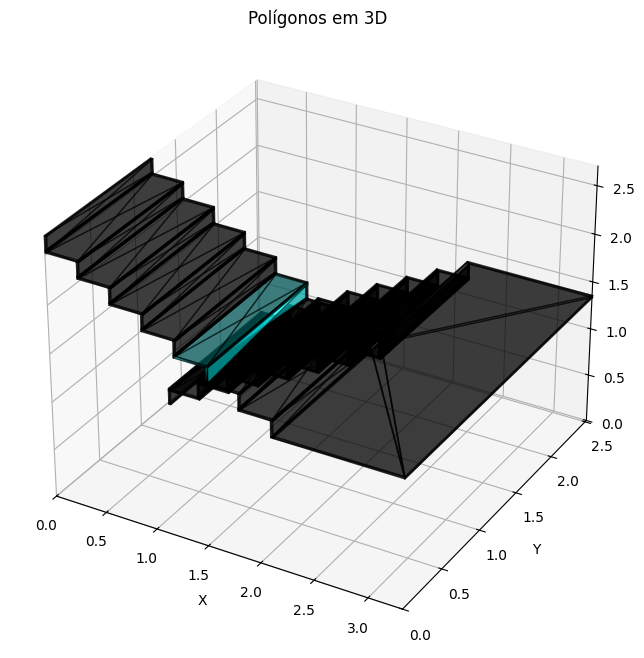

In [9]:
# Criar figura e eixo 3D fora do loop
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.viridis(np.linspace(0, 1, len(z_groups)))  # Paleta de cores variada
# Inicializar listas para definir limites do gráfico dinamicamente
all_x, all_y, all_z = [], [], []

for polygon in polygons:
    if len(polygon)==9:
        vert_polygon = np.array(polygon).reshape(-1, 3)
        vertices_polygons = []

        for vert in vert_polygon:
            vertices_polygons.append(vert)
        v1, v2, v3 = vertices_polygons[0] , vertices_polygons[1], vertices_polygons[2]

         # Adicionar os pontos aos limites globais
        all_x.extend(vert_polygon[:, 0])
        all_y.extend(vert_polygon[:, 1])
        all_z.extend(vert_polygon[:, 2])

        if np.isclose(v3[2], 1.84999871):
          color = 'cyan'
        else:
          color = 'k'

        # Adicionar o polígono ao gráfico
        ax.add_collection3d(Poly3DCollection([vert_polygon], color= color, alpha=0.5, edgecolor='k'))

ax.set_xlim([min(all_x), max(all_x)])
ax.set_ylim([min(all_y), max(all_y)])
ax.set_zlim([min(all_z), max(all_z)])

# Definir rótulos e título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Polígonos em 3D')

# Exibir o gráfico final
plt.show()

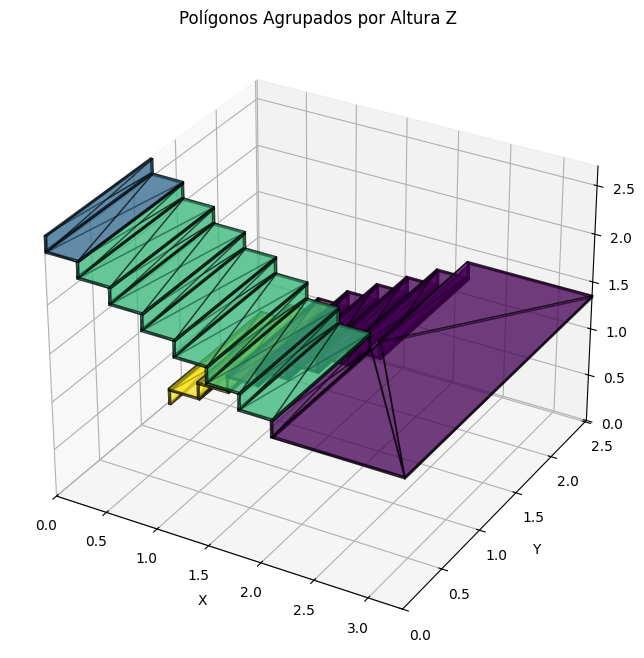

In [11]:
import ifcopenshell
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



def get_reps(elemento):
    rep = elemento.Representation
    reps = rep.Representations[1] if len(rep.Representations) > 1 else rep.Representations[0]
    items = reps.Items[0] if reps.Items else None
    return reps, items

# Obter Representação Geométrica
reps, items = get_reps(escada)

polygons = []
z_groups = {}

for fbsm in items.FbsmFaces:
    if fbsm.is_a("IfcConnectedFaceSet"):
        for face in fbsm.CfsFaces:
            for bound in face.Bounds:
                if bound.is_a("IfcFaceOuterBound"):
                    polygon = [list(verts.Coordinates) for verts in bound.Bound.Polygon]
                    if polygon and len(polygon) >= 3:
                        polygons.append(polygon)

                        # Usar a altura média do polígono para agrupamento
                        z_mean = round(np.mean([p[2] for p in polygon]))  # Arredondar para evitar variações muito pequenas

                        if z_mean not in z_groups:
                            z_groups[z_mean] = []
                        z_groups[z_mean].append(polygon)

# Criar Figura 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Definir cores para os grupos
colors = plt.cm.viridis(np.linspace(0, 1, len(z_groups)))  # Paleta de cores variada

# Plotar os polígonos agrupados por altura Z
for (z_val, poly_group), color in zip(z_groups.items(), colors):
    for polygon in poly_group:
        polygon_np = np.array(polygon)
        ax.add_collection3d(Poly3DCollection([polygon_np], color=color, alpha=0.5, edgecolor='k'))

# Ajustar Limites
all_x, all_y, all_z = np.array(polygons).reshape(-1, 3).T
ax.set_xlim([min(all_x), max(all_x)])
ax.set_ylim([min(all_y), max(all_y)])
ax.set_zlim([min(all_z), max(all_z)])

# Configurar Rótulos
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Polígonos Agrupados por Altura Z')

plt.show()



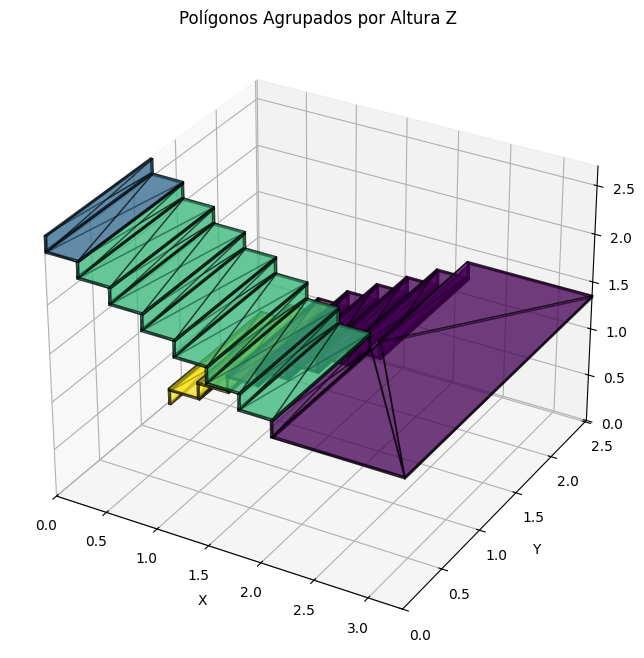

In [13]:
import ifcopenshell
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def get_reps(elemento):
    rep = elemento.Representation
    reps = rep.Representations[1] if len(rep.Representations) > 1 else rep.Representations[0]
    items = reps.Items[0] if reps.Items else None
    return reps, items

# Obter Representação Geométrica
reps, items = get_reps(escada)

polygons = []
z_groups = {}

for fbsm in items.FbsmFaces:
    if fbsm.is_a("IfcConnectedFaceSet"):
        for face in fbsm.CfsFaces:
            for bound in face.Bounds:
                if bound.is_a("IfcFaceOuterBound"):
                    polygon = [list(verts.Coordinates) for verts in bound.Bound.Polygon]
                    if polygon and len(polygon) >= 3:
                        polygons.append(polygon)

                        # Usar a altura média do polígono para agrupamento
                        z_mean = round(np.mean([p[2] for p in polygon]))  # Arredondar para evitar variações muito pequenas

                        if z_mean not in z_groups:
                            z_groups[z_mean] = []
                        z_groups[z_mean].append(polygon)

# Criar Figura 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Definir cores para os grupos
colors = plt.cm.viridis(np.linspace(0, 1, len(z_groups)))  # Paleta de cores variada

# Plotar os polígonos agrupados por altura Z
for (z_val, poly_group), color in zip(z_groups.items(), colors):
    for polygon in poly_group:
        polygon_np = np.array(polygon)
        ax.add_collection3d(Poly3DCollection([polygon_np], color=color, alpha=0.5, edgecolor='k'))

# Ajustar Limites
all_x, all_y, all_z = np.array(polygons).reshape(-1, 3).T
ax.set_xlim([min(all_x), max(all_x)])
ax.set_ylim([min(all_y), max(all_y)])
ax.set_zlim([min(all_z), max(all_z)])

# Configurar Rótulos
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Polígonos Agrupados por Altura Z')

plt.show()


In [12]:
import ifcopenshell
import numpy as np

def calcular_area_poligono(vertices):
    """Calcula a área de um polígono 3D projetando para 2D."""
    if len(vertices) < 3:
        return 0  # Não é um polígono válido

    # Converter a lista de vértices para um array numpy
    vertices = np.array(vertices)

    # Selecionar os eixos dominantes (ignorar o menor eixo de variação)
    variances = np.var(vertices, axis=0)  # Variância em X, Y, Z
    menor_variancia = np.argmin(variances)  # Eixo com menor variação

    # Projetar para um plano 2D removendo o eixo de menor variação
    vertices_2d = np.delete(vertices, menor_variancia, axis=1)

    # Usar a fórmula do polígono para calcular a área em 2D
    x, y = vertices_2d[:, 0], vertices_2d[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area


# Função para obter a representação geométrica
def get_reps(elemento):
    rep = elemento.Representation
    reps = rep.Representations[1] if len(rep.Representations) > 1 else rep.Representations[0]
    items = reps.Items[0] if reps.Items else None
    return reps, items

# Obter representação geométrica
reps, items = get_reps(escada)

# Calcular a área total
area_total = 0
if items:
    for fbsm in items.FbsmFaces:
        if fbsm.is_a("IfcConnectedFaceSet"):
            for face in fbsm.CfsFaces:
                for bound in face.Bounds:
                    if bound.is_a("IfcFaceOuterBound"):
                        poligono = [list(vert.Coordinates) for vert in bound.Bound.Polygon]
                        if len(poligono) >= 3:
                            area_total += calcular_area_poligono(poligono)

print(f"Área total da escada: {area_total:.2f} m²")


Área total da escada: 24.37 m²


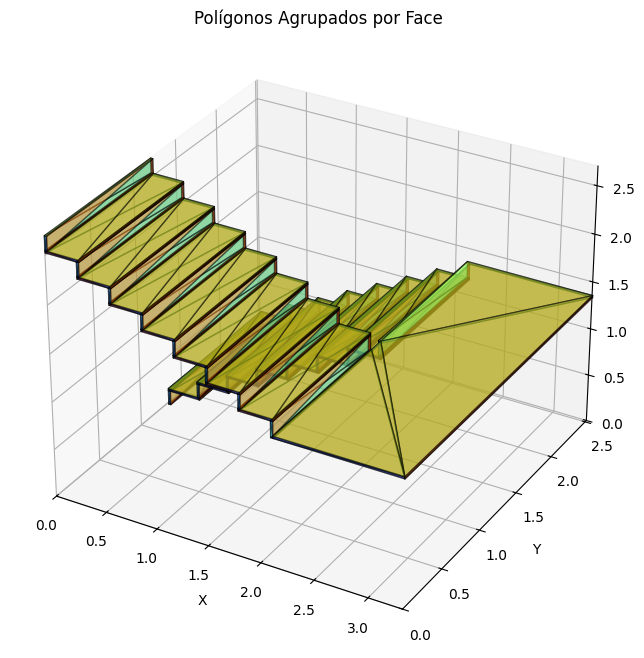

In [15]:
def get_reps(elemento):
    """ Obtém representações geométricas do elemento """
    rep = elemento.Representation
    reps = rep.Representations[1] if len(rep.Representations) > 1 else rep.Representations[0]
    items = reps.Items[0] if reps.Items else None
    return reps, items

# Obter Representação Geométrica
reps, items = get_reps(escada)

polygons = []
face_groups = {}

for fbsm in items.FbsmFaces:
    if fbsm.is_a("IfcConnectedFaceSet"):
        for face in fbsm.CfsFaces:
            face_polygons = []
            for bound in face.Bounds:
                if bound.is_a("IfcFaceOuterBound"):
                    polygon = [list(verts.Coordinates) for verts in bound.Bound.Polygon]
                    if polygon and len(polygon) >= 3:
                        face_polygons.append(polygon)
                        polygons.append(polygon)

            if face_polygons:
                # Calcular normal média da face para agrupamento
                poly_np = np.array(face_polygons[0])
                v1, v2, v3 = poly_np[0], poly_np[1], poly_np[2]
                normal = np.cross(v2 - v1, v3 - v1)
                normal = normal / np.linalg.norm(normal)  # Normalizar vetor

                # Usar a normal como chave para agrupamento
                normal_key = tuple(np.round(normal, 3))  # Arredondar para evitar variações numéricas

                if normal_key not in face_groups:
                    face_groups[normal_key] = []
                face_groups[normal_key].extend(face_polygons)

# Criar Figura 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Gerar cores únicas para cada grupo de faces
colors = plt.cm.jet(np.linspace(0, 1, len(face_groups)))

# Plotar os polígonos agrupados por face
for (normal_key, poly_group), color in zip(face_groups.items(), colors):
    for polygon in poly_group:
        polygon_np = np.array(polygon)
        ax.add_collection3d(Poly3DCollection([polygon_np], color=color, alpha=0.5, edgecolor='k'))

# Ajustar Limites
all_x, all_y, all_z = np.array(polygons).reshape(-1, 3).T
ax.set_xlim([min(all_x), max(all_x)])
ax.set_ylim([min(all_y), max(all_y)])
ax.set_zlim([min(all_z), max(all_z)])

# Configurar Rótulos
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Polígonos Agrupados por Face')

plt.show()